# Author: Benji Wagner

## Prediction with MRI Scans

In this notebook, I am trying my hand at Deep Learning for the first time. If you're reading this and have any suggestions on how to improve my approach, send me an email at benjiwagner1234@gmail.com

For version control purposes, we choose to use tensorflow version 1.12.0

In [3]:
!pip install tensorflow==1.12.0

    100% |████████████████████████████████| 83.1MB 392kB/s 
    100% |████████████████████████████████| 3.1MB 8.7MB/s 
  Found existing installation: tensorboard 1.13.0
    Uninstalling tensorboard-1.13.0:
      Successfully uninstalled tensorboard-1.13.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!ls "gdrive/My Drive/Data"

LGG-segmentation.zip


In [0]:
!unzip -q "gdrive/My Drive/Data/LGG-segmentation.zip"

In [7]:
!ls LGG-segmentation/ | head

data.csv
README.md
TCGA_CS_4941_19960909
TCGA_CS_4942_19970222
TCGA_CS_4943_20000902
TCGA_CS_4944_20010208
TCGA_CS_5393_19990606
TCGA_CS_5395_19981004
TCGA_CS_5396_20010302
TCGA_CS_5397_20010315


In [8]:
!ls LGG-segmentation/TCGA_CS_4941_19960909 | head

TCGA_CS_4941_19960909_10_mask.tif
TCGA_CS_4941_19960909_10.tif
TCGA_CS_4941_19960909_11_mask.tif
TCGA_CS_4941_19960909_11.tif
TCGA_CS_4941_19960909_12_mask.tif
TCGA_CS_4941_19960909_12.tif
TCGA_CS_4941_19960909_13_mask.tif
TCGA_CS_4941_19960909_13.tif
TCGA_CS_4941_19960909_14_mask.tif
TCGA_CS_4941_19960909_14.tif


Here are specific columns with labels that we want to predict:


* COCCluster - 3 classes (1=COC1, 2=COC2, 3=COC3) available for all patients

* neoplasm_histologic_grade - 2 classes (1=Grade I, 2=Grade II) and not available for 1 patient
  * Grade l = cells are well-differentiated
  * Grade ll = cells are poorly-differentiated



Each folder contains MRI scans with the following naming convention:

`TCGA_<institution-code>_<patient-id>_<slice-number>.tif`

In [9]:
import pandas as pd
metadata = pd.read_csv("LGG-segmentation/data.csv")
metadata.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Using TensorFlow backend.


In [11]:
temp = plt.imread('LGG-segmentation/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif')
print(temp.shape)

(256, 256, 3)


Each image is 256 x 256 pixels. Additionally, there are 3 channels. Usually, these channels are for red, green, and blue color channels, but MRI scans are a little different. Instead, the three channels are `Pre-Contrast`, fluid-attenuated inversion recovery (`FLAIR`), and `Post-Contrast`.

In [0]:
# input image dimensions
img_rows, img_cols = 256, 256

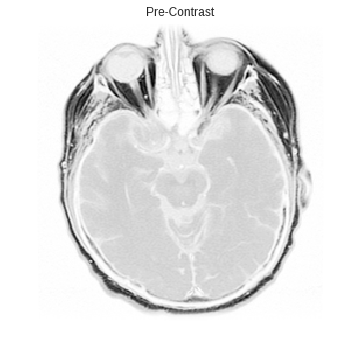

In [13]:
# pre-contrast
plt.imshow(temp[:,:,0]);
plt.title("Pre-Contrast");
plt.axis("off");

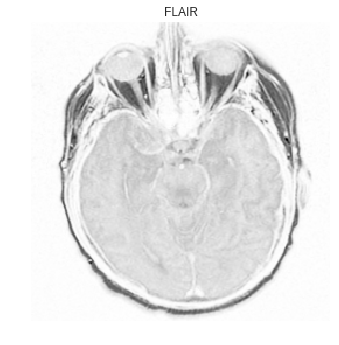

In [14]:
# FLAIR
plt.imshow(temp[:,:,1]);
plt.title("FLAIR");
plt.axis("off");

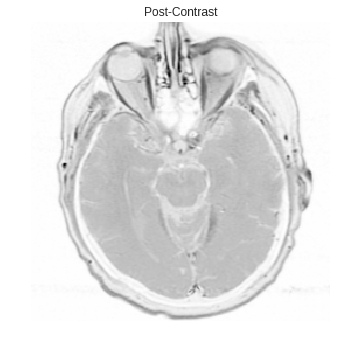

In [15]:
# post-contrast
plt.imshow(temp[:,:,2]);
plt.title("Post-Contrast");
plt.axis("off");

Now, let's start by putting all the relevant files into a list.

In [0]:
import glob
import os

file_list = glob.glob(os.path.join(os.getcwd(), "LGG-segmentation/TCGA_*/", "*[!_mask].tif"))

In [17]:
len(file_list)

3929

Below is the code for getting the pixel values for each image

In [0]:
images = []
for file_path in file_list:
    images.append(plt.imread(file_path))
images = np.asarray(images)

Getting the labels into the correct format will be tricky. We must:



*   Extract the Patient IDs from `file_list` so as to maintain a consistent order with the pixel information
*   Match the Patient IDs with their corresponding `neoplasm_histologic_grade` from `data.csv`
*   Look for patients with a missing response and correspondingly remove these observations from our features dataset



In [0]:
import re
patients = []
for f in file_list:
  patients.append(re.search("TCGA_[A-Z]{2,}_[0-9A-Z]{4,}", f).group(0))

In [0]:
full_df = pd.DataFrame(patients, columns = ["Patient"]).merge(right = metadata, on = "Patient", how = "left")

Below we see that Patient TCGA_HT_A61B is missing their `neoplasm_histologic_grade` values. Therefore we will drop them from the dataset, but we must be careful to also drop the corresponding images in the features dataset.

In [21]:
full_df[full_df['neoplasm_histologic_grade'].isna()].head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
2266,TCGA_HT_A61B,NaN,5.0,2,1.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2267,TCGA_HT_A61B,NaN,5.0,2,1.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2268,TCGA_HT_A61B,NaN,5.0,2,1.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2269,TCGA_HT_A61B,NaN,5.0,2,1.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2270,TCGA_HT_A61B,NaN,5.0,2,1.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
full_df_neoplasm = full_df.dropna(subset = ["neoplasm_histologic_grade"])
labels = (np.asarray(full_df_neoplasm["neoplasm_histologic_grade"].values) - 1).astype('int') # Want 0's and 1's, not 1's and 2's.

In [23]:
full_df.shape[0] - labels.shape[0]

88

We removed 88 observations from our data due to missing `neoplasm_histologic_grade`

In [0]:
neoplasm_indices = full_df_neoplasm.index

In [25]:
images[neoplasm_indices].shape

(3841, 256, 256, 3)

After removing the patients with a missing response, we have 3841 total scans to use in our analysis. 

# Training our Neural Network

Below we will try testing several different models by tweaking things one at a time. We will try altering:
* Channel Input (1 vs 3)
* Depth of Neural Network
  * Which layers increase accuracy?
* Training to Test Split Size
* Artificially increasing our dataset via Image Transformations

### Train/Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(images[neoplasm_indices], labels, random_state = 2019, test_size = 0.33)

### Hyperparameters

In [0]:
batch_size = 64
num_classes = 2
epochs = 5

In [28]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (2573, 256, 256, 3)
2573 train samples
1268 test samples


In [0]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Flatten())
model.add(Dense(num_classes, activation='sigmoid'))

In [40]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Train on 2573 samples, validate on 1268 samples
Epoch 1/5
2573/2573 [==============================] - 409s 159ms/step - loss: 1.8132 - acc: 0.6032 - val_loss: 0.8381 - val_acc: 0.6542
Epoch 2/5
2573/2573 [==============================] - 411s 160ms/step - loss: 0.6704 - acc: 0.7641 - val_loss: 0.6640 - val_acc: 0.7827
Epoch 3/5
2573/2573 [==============================] - 409s 159ms/step - loss: 0.4762 - acc: 0.8731 - val_loss: 0.7742 - val_acc: 0.7082
Epoch 4/5
2573/2573 [==============================] - 411s 160ms/step - loss: 0.3906 - acc: 0.9180 - val_loss: 0.7854 - val_acc: 0.7323
Epoch 5/5
2573/2573 [==============================] - 409s 159ms/step - loss: 0.3337 - acc: 0.9440 - val_loss: 0.6108 - val_acc: 0.8143
Test loss: 0.6107769140309716
Test accuracy: 0.8142744483255814


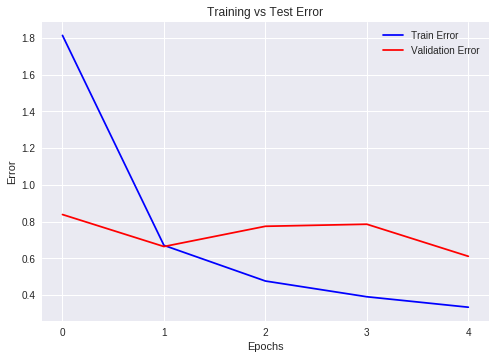

In [41]:
fig = plt.figure()
plt.plot(hist.history["loss"], 'b', label = "Train Error");
plt.plot(hist.history["val_loss"], 'r', label = "Validation Error");
plt.title("Training vs Test Error");
plt.legend(loc = "upper right");
plt.xticks(np.arange(0, epochs, 1));
plt.xlabel("Epochs");
plt.ylabel("Error");

We see the following model:

```
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Flatten())
model.add(Dense(num_classes, activation='sigmoid'))
```
gives us a loss of `0.6107769140309716` and accuracy of `0.8142744483255814` after 5 epochs.

Additionally, it takes ~400 seconds/epoch to run.


In [0]:
fig.savefig("gdrive/My Drive/Output/MRI_Prediction_Plots/errorplot_hiddenlayers0_batch64_epochs5_training2573_test1268.png")

In [0]:
predictions = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), predictions.ravel())
model_auc = auc(fpr, tpr)

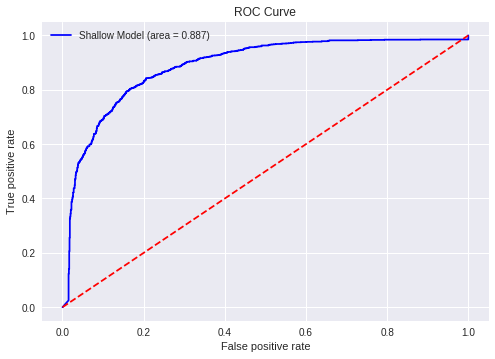

In [87]:
fig = plt.figure()
plt.plot(fpr, tpr, 'b-', label = "Shallow Model (area = {:.3f})".format(model_auc));
plt.plot([0, 1], [0, 1], 'r--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.title('ROC Curve');
plt.legend(loc='best');

In [0]:
fig.savefig("gdrive/My Drive/Output/MRI_Prediction_Plots/roc_hiddenlayers0_batch64_epochs5_training2573_test1268.png")

Let's try adding a hidden layer with regularization to our model.

In [37]:
epochs = 5

model1 = Sequential()
model1.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(Dropout(0.2))
model1.add(MaxPooling2D(pool_size=(3, 3)))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(num_classes, activation='sigmoid'))

model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

hist = model1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model1.evaluate(X_test, y_test, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Train on 2573 samples, validate on 1268 samples
Epoch 1/5
2573/2573 [==============================] - 573s 223ms/step - loss: 0.7306 - acc: 0.5892 - val_loss: 0.5908 - val_acc: 0.7129
Epoch 2/5
2573/2573 [==============================] - 576s 224ms/step - loss: 0.5235 - acc: 0.7281 - val_loss: 0.5273 - val_acc: 0.7394
Epoch 3/5
2573/2573 [==============================] - 578s 225ms/step - loss: 0.4029 - acc: 0.8255 - val_loss: 0.4534 - val_acc: 0.7808
Epoch 4/5
2573/2573 [==============================] - 575s 224ms/step - loss: 0.3172 - acc: 0.8700 - val_loss: 0.4492 - val_acc: 0.7662
Epoch 5/5
2573/2573 [==============================] - 577s 224ms/step - loss: 0.2647 - acc: 0.8947 - val_loss: 0.3916 - val_acc: 0.8147

Test loss: 0.39160107118474197
Test accuracy: 0.8146687697160884


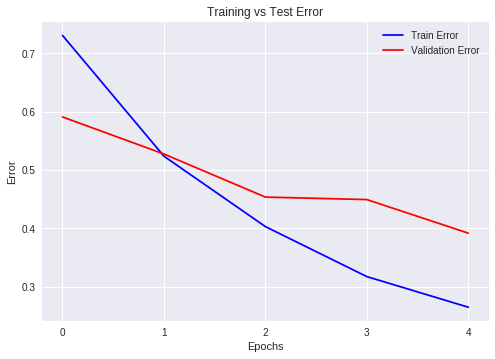

In [38]:
fig = plt.figure()
plt.plot(hist.history["loss"], 'b', label = "Train Error");
plt.plot(hist.history["val_loss"], 'r', label = "Validation Error");
plt.title("Training vs Test Error");
plt.legend(loc = "upper right");
plt.xticks(np.arange(0, epochs, 1));
plt.xlabel("Epochs");
plt.ylabel("Error");

We see the following model:



```
model1 = Sequential()
model1.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(Dropout(0.2))
model1.add(MaxPooling2D(pool_size=(3, 3)))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(num_classes, activation='sigmoid'))

```


gives us a loss of `0.39160107118474197` and accuracy of `0.8146687697160884` after 5 epochs.

Additionally, it takes ~10 min/epoch to run.

In [0]:
fig.savefig("gdrive/My Drive/Output/MRI_Prediction_Plots/errorplot_hiddenlayers1_batch64_epochs5_training2573_test1268.png")

In [0]:
predictions = model1.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), predictions.ravel())
model_auc = auc(fpr, tpr)

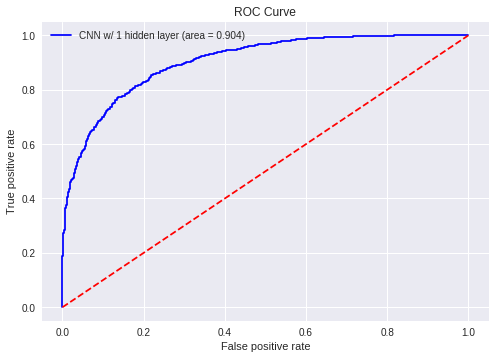

In [41]:
fig = plt.figure()
plt.plot(fpr, tpr, 'b-', label = "CNN w/ 1 hidden layer (area = {:.3f})".format(model_auc));
plt.plot([0, 1], [0, 1], 'r--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.title('ROC Curve');
plt.legend(loc='best');

In [0]:
fig.savefig("gdrive/My Drive/Output/MRI_Prediction_Plots/roc_hiddenlayers1_batch64_epochs5_training2573_test1268.png")

Interesting. Our model with an additional hidden layer has less accuracy than our shallow model. I speculate it may be because we need another dense layer after our pooling layer.

In [0]:
epochs = 5

model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Dropout(0.2))
#model.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(num_classes, activation='sigmoid'))

model2.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

hist = model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model2.evaluate(X_test, y_test, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Train on 2573 samples, validate on 1268 samples
Epoch 1/5
2573/2573 [==============================] - 696s 271ms/step - loss: 0.9204 - acc: 0.5484 - val_loss: 0.6639 - val_acc: 0.6735
Epoch 2/5
2573/2573 [==============================] - 696s 271ms/step - loss: 0.6026 - acc: 0.6634 - val_loss: 0.5733 - val_acc: 0.7102
Epoch 3/5
2573/2573 [==============================] - 695s 270ms/step - loss: 0.4998 - acc: 0.7427 - val_loss: 0.5274 - val_acc: 0.7303
Epoch 4/5
 128/2573 [>.............................] - ETA: 10:52 - loss: 0.3929 - acc: 0.8359

In [0]:
fig = plt.figure()
plt.plot(hist.history["loss"], 'b', label = "Train Error");
plt.plot(hist.history["val_loss"], 'r', label = "Validation Error");
plt.title("Training vs Test Error");
plt.legend(loc = "upper right");
plt.xticks(np.arange(0, epochs, 1));
plt.xlabel("Epochs");
plt.ylabel("Error");

We see the following model:

```
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Dropout(0.2))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(num_classes, activation='sigmoid'))
```


gives us a loss of 0.483812808614424 and accuracy of 0.7480283907911379

Additionally, it takes ~11.67 min/epoch to run.

In [0]:
fig.savefig("gdrive/My Drive/Output/MRI_Prediction_Plots/errorplot_hiddenlayers2_batch64_epochs5_training2573_test1268.png")

In [0]:
predictions = model2.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), predictions.ravel())
model_auc = auc(fpr, tpr)

In [0]:
fig = plt.figure()
plt.plot(fpr, tpr, 'b-', label = "CNN w/ 1 hidden layer (area = {:.3f})".format(model_auc));
plt.plot([0, 1], [0, 1], 'r--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.title('ROC Curve');
plt.legend(loc='best');

In [0]:
fig.savefig("gdrive/My Drive/Output/MRI_Prediction_Plots/roc_hiddenlayers2_batch64_epochs5_training2573_test1268.png")